In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data)
from scipy.stats import false_discovery_control
%load_ext rpy2.ipython

In [2]:
behavior = load_behavioral_data(min_RT = 0.2)
behavior['uncertain'] = behavior["response_int"].apply(lambda x: "Yes" if x == 2 or x == 3 else "No")
pupil_data = load_pupil_data()
data = pupil_data.merge(behavior, on=["sub", "trial"])
data["pupil_size"] = data["ps_preprocessed"] - data["baseline"]
data["gain"] = data["gain"] / 10
data["loss"] = data["loss"] / 10

In [3]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)
library(broom.mixed)

Loading required package: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.
Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



First, we examine if there are differences in the interaction between stimuli and pupil size. 

In [7]:
%%R -o results
# loop through timebins
results <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model = lmer(pupil_size ~ gain*condition + loss*condition + RT*condition + blink*condition + (1| sub) + (-1 + RT|sub) + (-1 + blink| sub) + (-1 + gain | sub) + (-1 + loss | sub), data=data[data$timebin == tb, ])
    # Gather results
    model_result <- tidy(model, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    model_result$timebin <- tb
    # Append results
    results <- rbind(results, model_result)
}

boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
In addition: Warning messages:
1: Model failed to converge with 1 negative eigenvalue: -4.7e+03 
2: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00274348 (tol = 0.002, component 1)


In [8]:
results["p.value"] = false_discovery_control(results["p.value"], method = "by")
results = results.rename(columns={"p.value": "p_value"})

In [9]:
# From this, all I want to look is at the pvalues that are significant
results = results.query("p_value < 0.05 & term.str.contains('conditionequalRange')")

In [10]:
gain_timebin = results.query("term.str.contains('gain')")["timebin"].values
loss_timebin = results.query("term.str.contains('loss')")["timebin"].values
RT_timebin = results.query("term.str.contains('RT')")["timebin"].values
blink_timebin = results.query("term.str.contains('blink')")["timebin"].values

In [11]:
%%R -o results_individual
# loop through timebins
results_individual <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    modelIndifference = lmer(pupil_size ~ gain + loss + RT + blink + (1| sub) + (-1 + RT|sub) + (-1 + blink| sub) + (-1 + gain | sub) + (-1 + loss | sub), data=data[data$timebin == tb & data$condition == 'equalIndifference', ])
    modelRange = lmer(pupil_size ~ gain + loss + blink + RT + (1| sub) + (-1 + RT|sub) + (-1 + blink| sub)+ (-1 + gain | sub) + (-1 + loss | sub), data=data[data$timebin == tb & data$condition == 'equalRange', ])
    # Gather results
    resultsIndifference <- tidy(modelIndifference, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    resultsRange <- tidy(modelRange, effects = "fixed", conf.int = TRUE, conf.level = 0.95)
    resultsIndifference$condition <- 'equalIndifference'
    resultsRange$condition <- 'equalRange'
    resultsIndifference$timebin <- tb
    resultsRange$timebin <- tb
    # Append results
    results_individual <- rbind(results_individual, resultsIndifference)
    results_individual <- rbind(results_individual, resultsRange)
}

boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
In addition: Warning messages:
1: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00267813 (tol = 0.002, component 1)
2: Model failed to converge with 1 negative eigenvalue: -1.0e+03 
3: In checkConv(attr(opt, 

In [12]:
results_individual["p.value"] = false_discovery_control(results_individual["p.value"], method = "by")
results_individual = results_individual.rename(columns={"p.value": "p_value"})

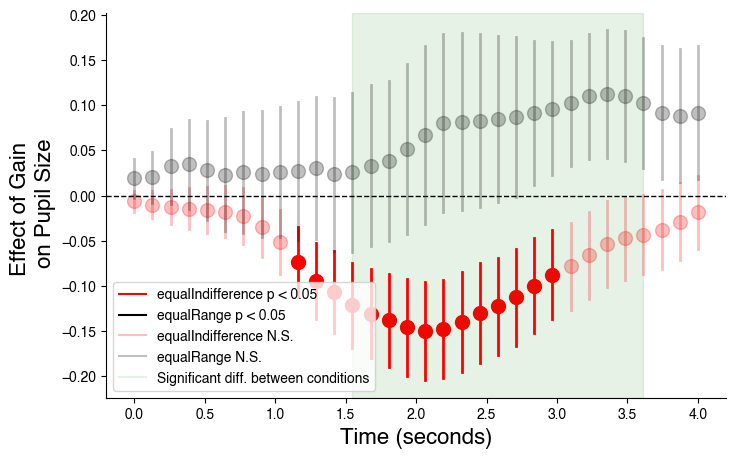

In [14]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'gain'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")

ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of Gain \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# Include shaded area for from min gain_timebin to max gain_timebin
if len(gain_timebin) > 0:
    ax.axvspan(min(gain_timebin), max(gain_timebin), color="green", alpha=0.1)
# plt.ylim(-0.02, 0.025)
plt.show()

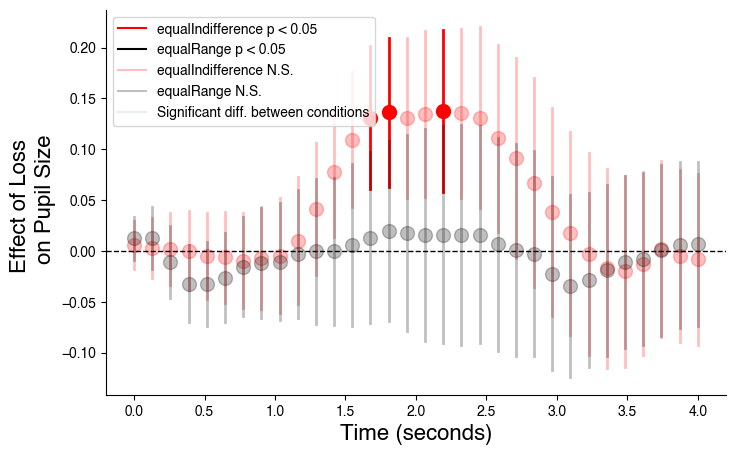

In [15]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'loss'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")

ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of Loss \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# Include shaded area for from min gain_timebin to max gain_timebin
if len(loss_timebin) > 0:
    ax.axvspan(min(loss_timebin), max(loss_timebin), color="green", alpha=0.1)
# plt.ylim(-0.02, 0.025)
plt.show()

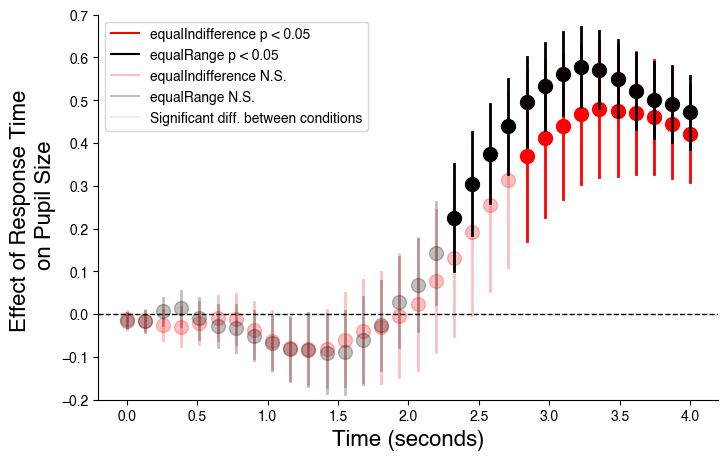

In [16]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'RT'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")

ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of Response Time \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# Include shaded area for from min gain_timebin to max gain_timebin
if len(RT_timebin) > 0:
    ax.axvspan(min(RT_timebin), max(RT_timebin), color="green", alpha=0.1)
ax.set_ylim(-0.2, 0.7)
plt.show()

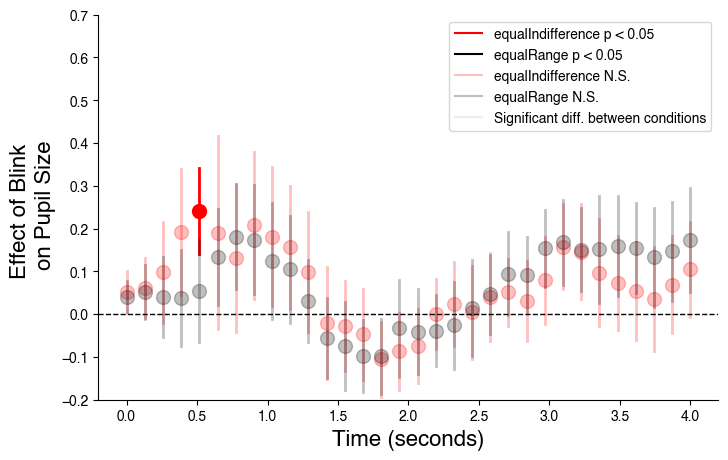

In [17]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'blink'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", alpha = 1, label="equalIndifference p < 0.05")
ax.plot([], [], color = "black", label="equalRange p < 0.05")
ax.plot([], [], color = "red", alpha = 0.25, label="equalIndifference N.S.")
ax.plot([], [], color = "black", alpha = 0.25, label="equalRange N.S.")
ax.plot([], [], color = "green", alpha = 0.1, label="Significant diff. between conditions")

ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of Blink \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# Include shaded area for from min gain_timebin to max gain_timebin
if len(blink_timebin) > 0:
    ax.axvspan(min(blink_timebin), max(blink_timebin), color="green", alpha=0.1)
ax.set_ylim(-0.2, 0.7)
plt.show()